<a href="https://colab.research.google.com/github/amisq987/uber/blob/main/Uber2014MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Pre-cleaning and visualisation tools
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Machine learning tools
import xgboost as xgb
from sklearn.model_selection import KFold
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
uber2014 = pd.read_csv('/content/uber_processed.csv')

In [26]:
uber2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4451746 entries, 0 to 4451745
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Date_time   object 
 1   Lat         float64
 2   Lon         float64
 3   Base        object 
 4   month       int64  
 5   weekday     object 
 6   day         int64  
 7   hour        int64  
 8   minute      int64  
 9   weekday_vi  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 339.6+ MB


In [27]:
def PlotDecomposition(result):
    plt.figure(figsize=(22,18))
    plt.subplot(4,1,1)
    plt.plot(result.observed,label='Observed',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4,1,2)
    plt.plot(result.trend,label='Trend',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonality',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals',lw=1)
    plt.legend(loc='upper left')
    plt.show()

def CalculateError(pred,sales):
  percentual_errors = []
  for A_i, B_i in zip(sales, pred):
    percentual_error = abs((A_i - B_i) / B_i)
    percentual_errors.append(percentual_error)
  return sum(percentual_errors) / len(percentual_errors)

def PlotPredictions(plots,title):
    plt.figure(figsize=(18, 8))
    for plot in plots:
        plt.plot(plot[0], plot[1], label=plot[2], linestyle=plot[3], color=plot[4],lw=1)
    plt.xlabel('Date')
    plt.ylabel("Trips")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.show()


def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [28]:
# Now make sure the date column is set to datetime, sorted and with an adequate name
uber2014['Date_time'] = pd.to_datetime(uber2014['Date_time'], format='%Y-%m-%d %H:%M:%S')
uber2014 = uber2014.sort_values(by='Date_time')
uber2014 = uber2014.rename(columns={'Date_time':'Date'})
uber2014.set_index('Date',inplace=True)

In [29]:
uber2014.head(2)

,Lat,Lon,Base,month,weekday,day,hour,minute,weekday_vi
Date,,,,,,,,,
2014-04-01,40.7637,-73.9600,B02598,4,Tuesday,1,0,0,Thứ 3
2014-04-01,40.7188,-73.9863,B02598,4,Tuesday,1,0,0,Thứ 3


In [30]:
# Group by hour and count occurrences of 'Base'
hourly_counts = uber2014['Base'].resample('h').count()
# Convert the series to a dataframe
uber2014 = hourly_counts.reset_index()
# Rename columns for clarity
uber2014.columns = ['Date', 'Count']
uber2014.set_index('Date',inplace=True)

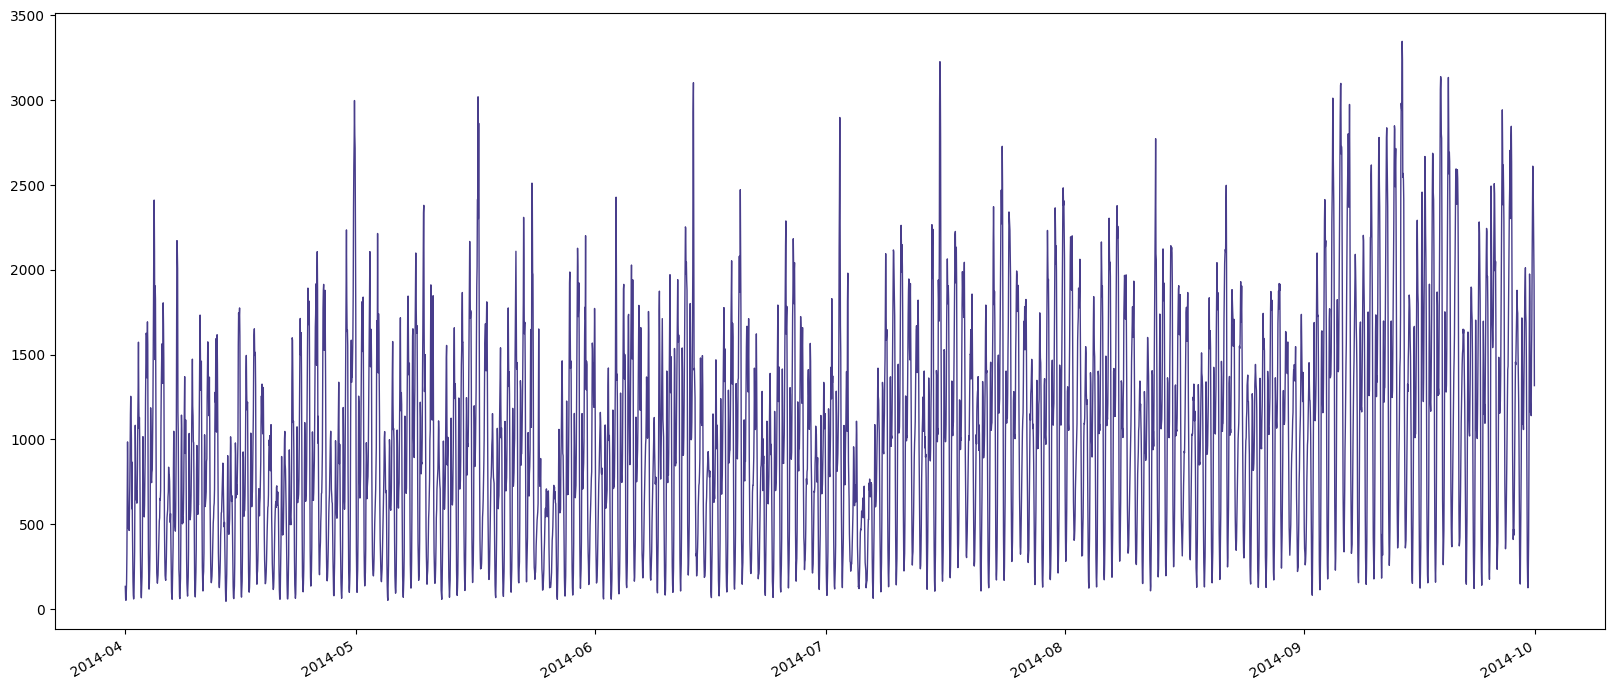

In [31]:
# Let's plot the series
plt.figure(figsize=(20, 8))
plt.plot(uber2014['Count'],linewidth = 1, color='darkslateblue')
plt.xticks(rotation=30,ha='right')
plt.show()

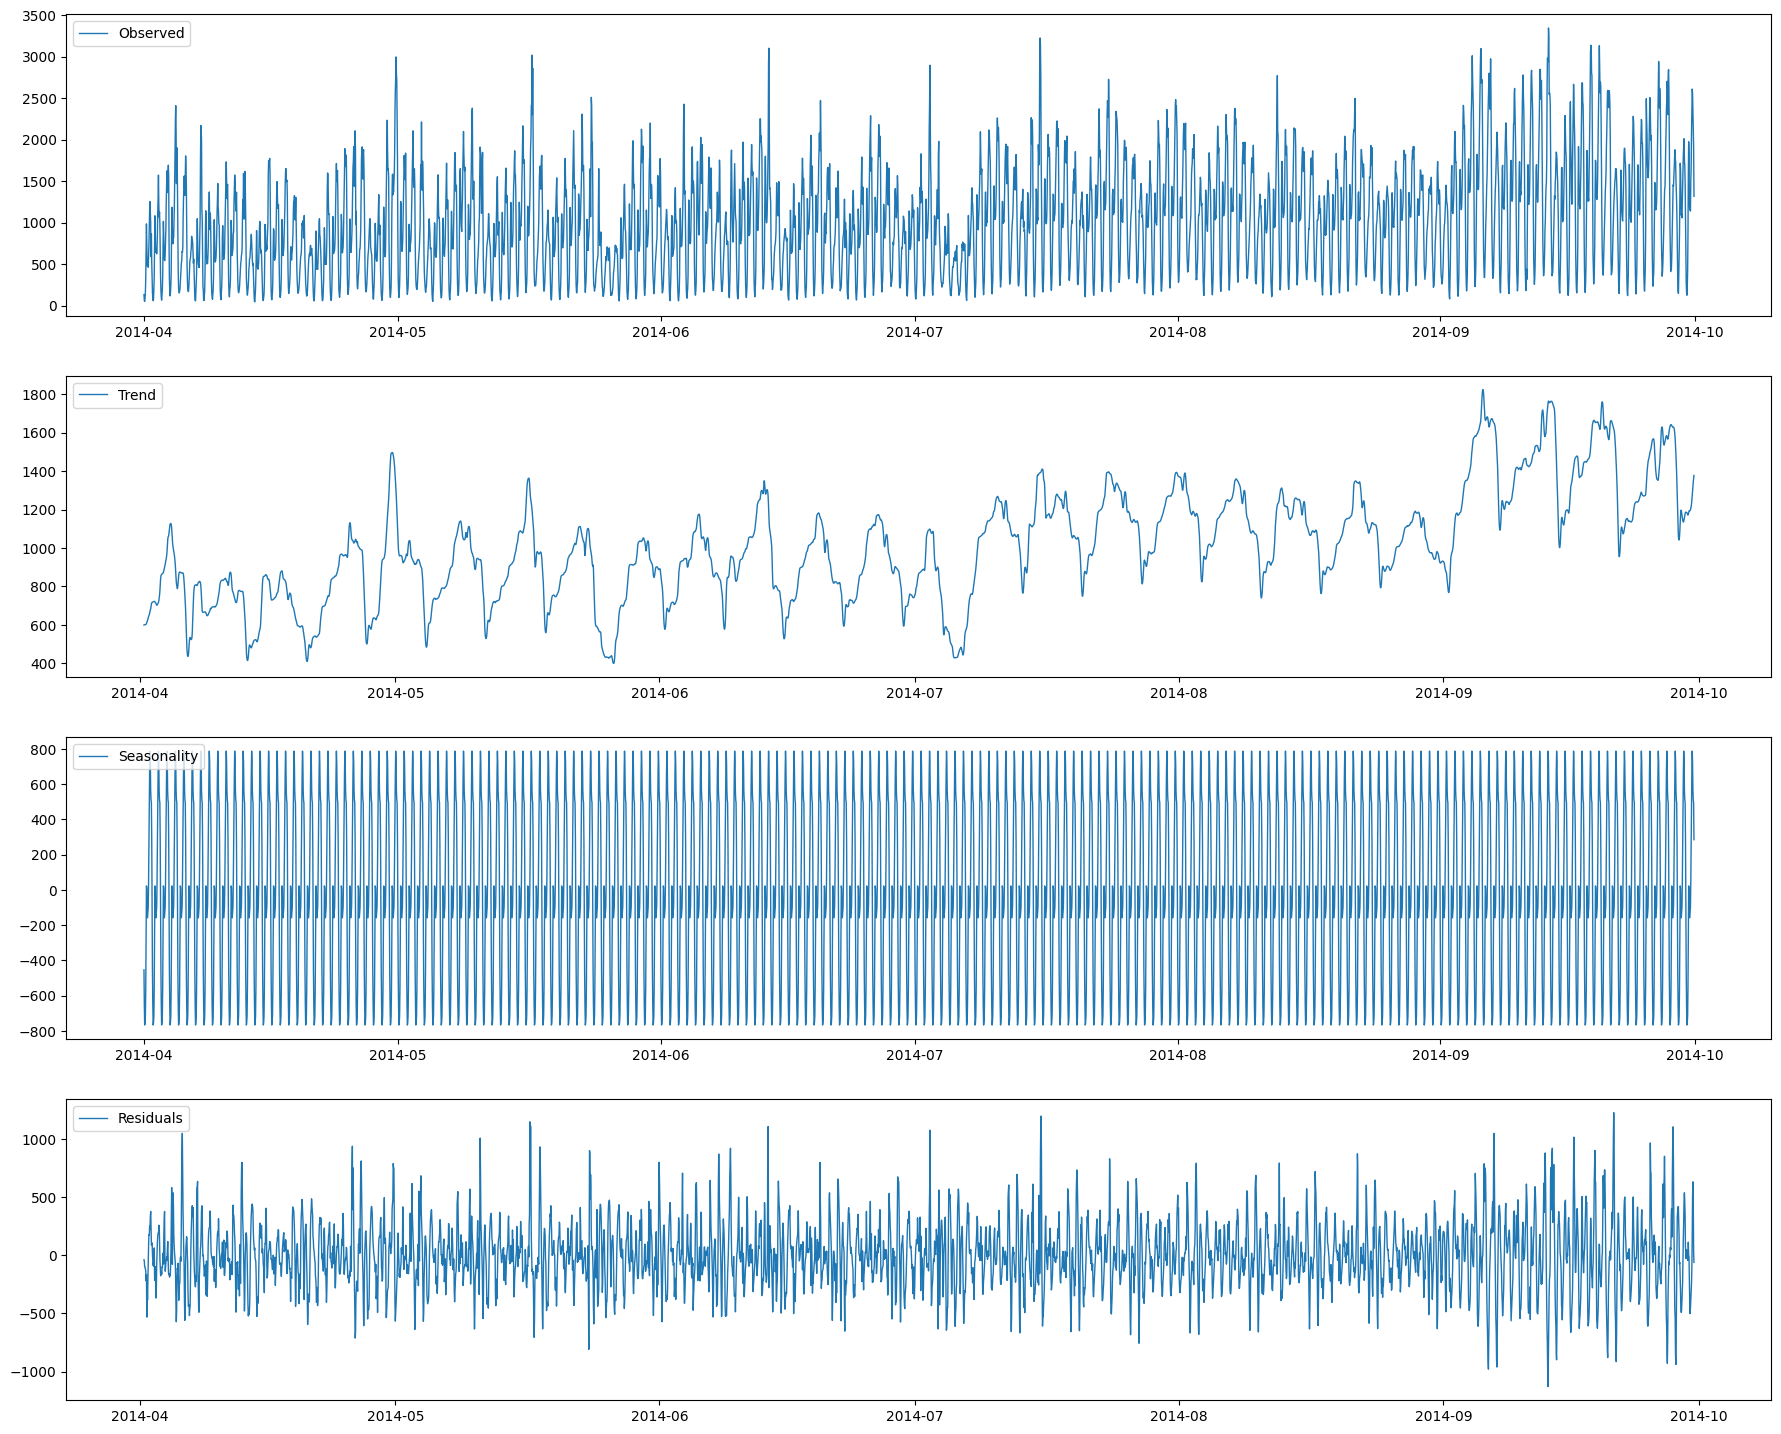

In [32]:
result=seasonal_decompose(uber2014['Count'],model='add', period=24*1)
PlotDecomposition(result)

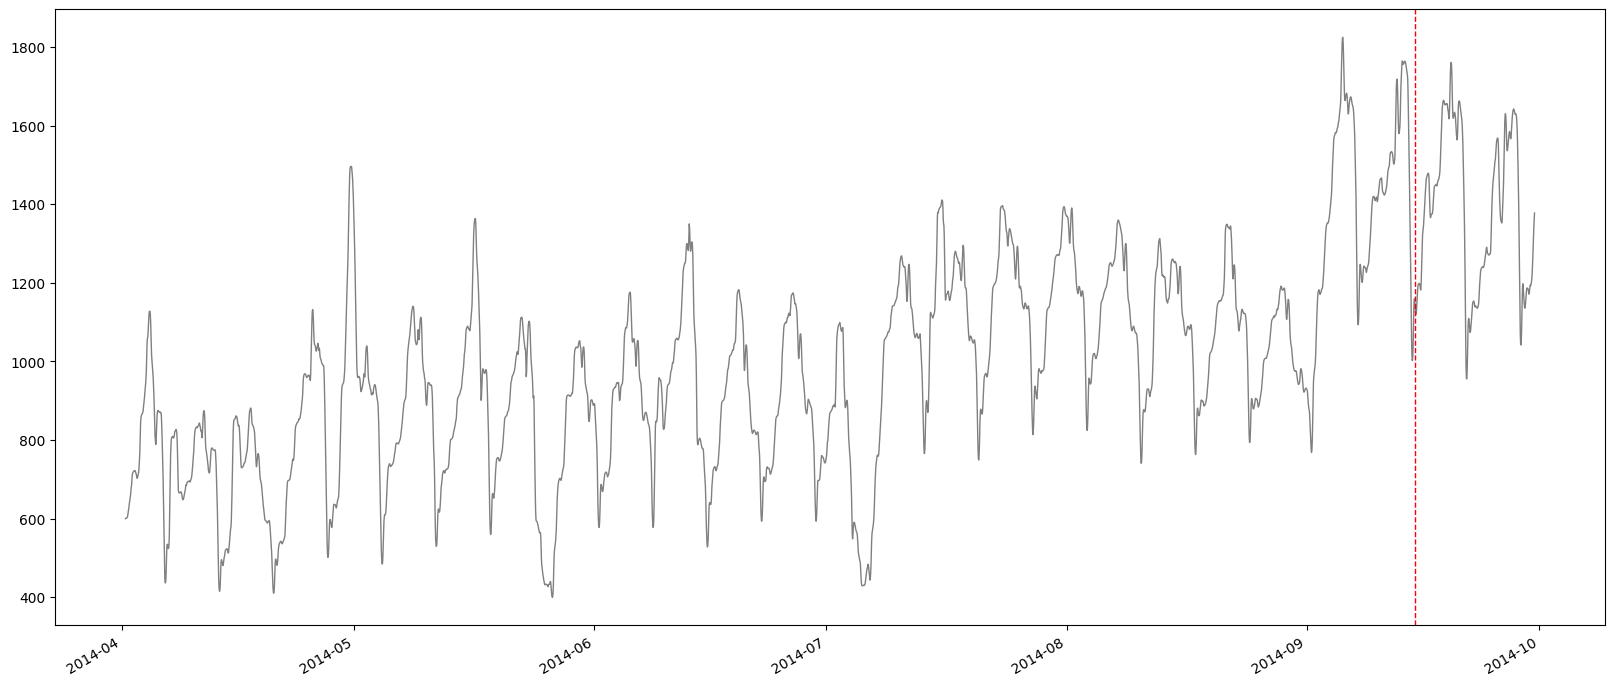

In [33]:
cutoff_date = '2014-09-15 00:00:00'
plt.figure(figsize=(20, 8))
plt.plot(result.trend, linewidth = 1, color='gray')
plt.axvline(x=pd.Timestamp(cutoff_date), color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=30, ha='right')
plt.show()

In [34]:
uber2014_train = uber2014.loc[:cutoff_date]
uber2014_test = uber2014.loc[cutoff_date:]

<Axes: title={'center': 'Train / Test Sets'}, xlabel='Date'>

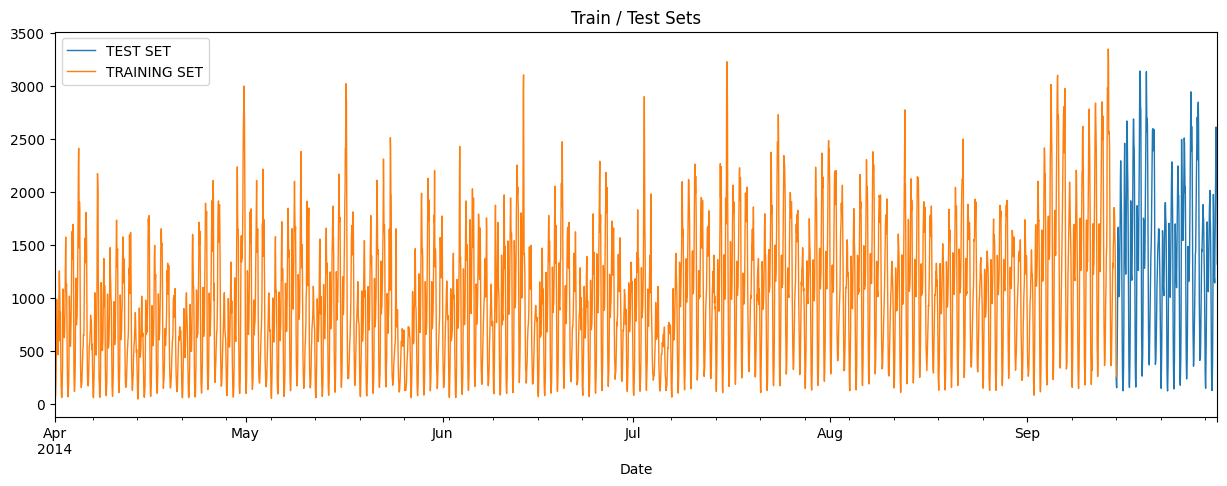

In [35]:
uber2014_test.rename(columns={'Count':'TEST SET'}).join(uber2014_train.rename(columns={'Count':'TRAINING SET'}), how='outer').plot(figsize=(15,5),title='Train / Test Sets', style='-',lw=1)

In [36]:
window_size = 24

# Tạo dữ liệu huấn luyện
X_train, y_train = create_lagged_features(uber2014_train['Count'].values, window_size)
 # Tạo dữ liệu kiểm tra
test_data = np.concatenate([uber2014_train['Count'].values[-window_size:], uber2014_test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window_size)

In [37]:
seed = 12345

XGBoost

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


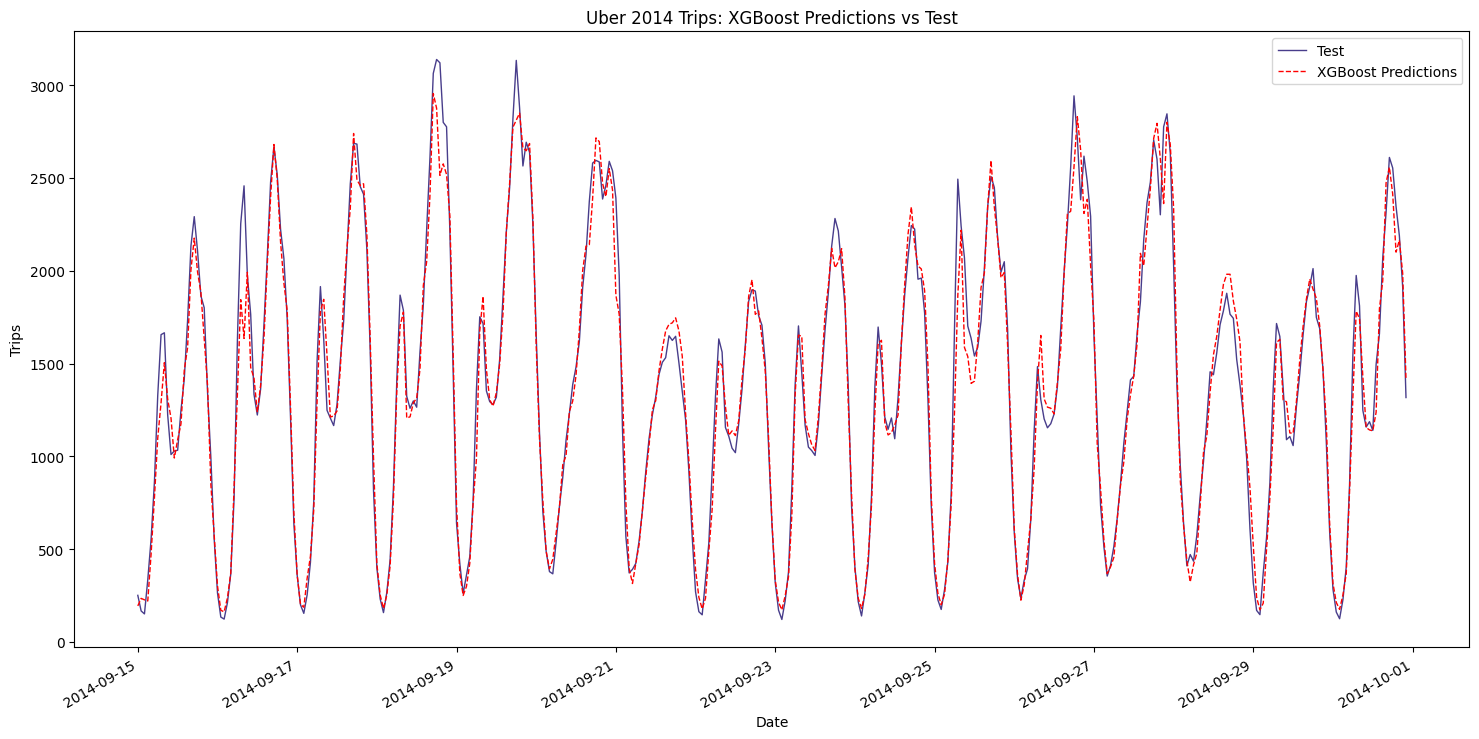

XGBoost MAPE:	8.63%


In [38]:
tscv = TimeSeriesSplit(n_splits=5)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)
xgb_grid_search.fit(X_train, y_train)
print("Best XGBoost parameters:", xgb_grid_search.best_params_)

xgb_predictions = xgb_grid_search.best_estimator_.predict(X_test)

PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'darkslateblue'),
    (uber2014_test.index, xgb_predictions, 'XGBoost Predictions', '--', 'red')
], 'Uber 2014 Trips: XGBoost Predictions vs Test')

xgb_mape = mean_absolute_percentage_error(uber2014_test['Count'], xgb_predictions)
print(f"XGBoost MAPE:\t{xgb_mape:.2%}")


Random Forests

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Random Forest parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


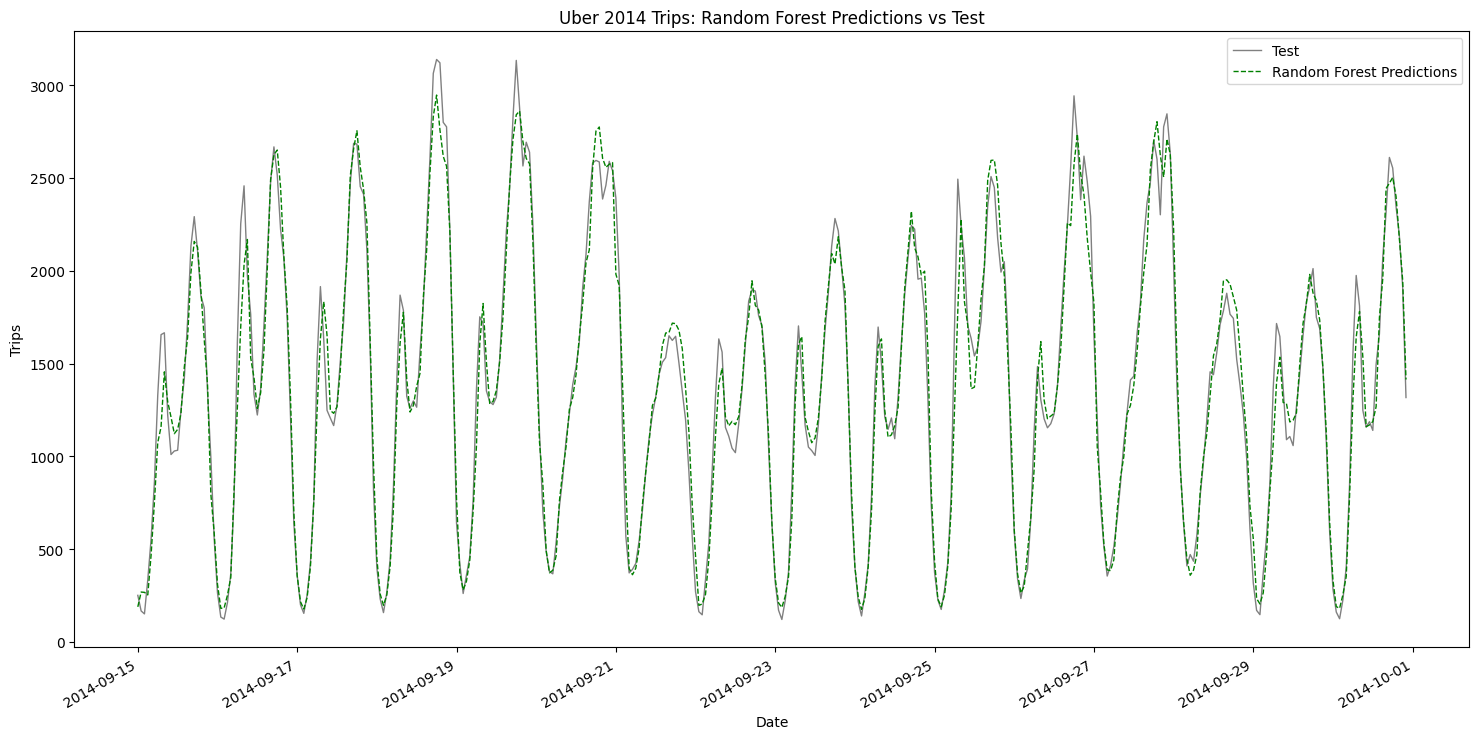

Random Forest Mean Percentage Error:	9.32%


In [39]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

rf_model = RandomForestRegressor(random_state=seed)

rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_grid_search.best_params_)

rf_predictions = rf_grid_search.best_estimator_.predict(X_test)

PlotPredictions([
   (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'gray'),
   (uber2014_test.index, rf_predictions, 'Random Forest Predictions', '--', 'green')
], 'Uber 2014 Trips: Random Forest Predictions vs Test')

rf_mape = mean_absolute_percentage_error(uber2014_test['Count'], rf_predictions)
print(f"Random Forest Mean Percentage Error:\t{rf_mape:.2%}")

Gradient Boosted Regression Tree

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Random Forest parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


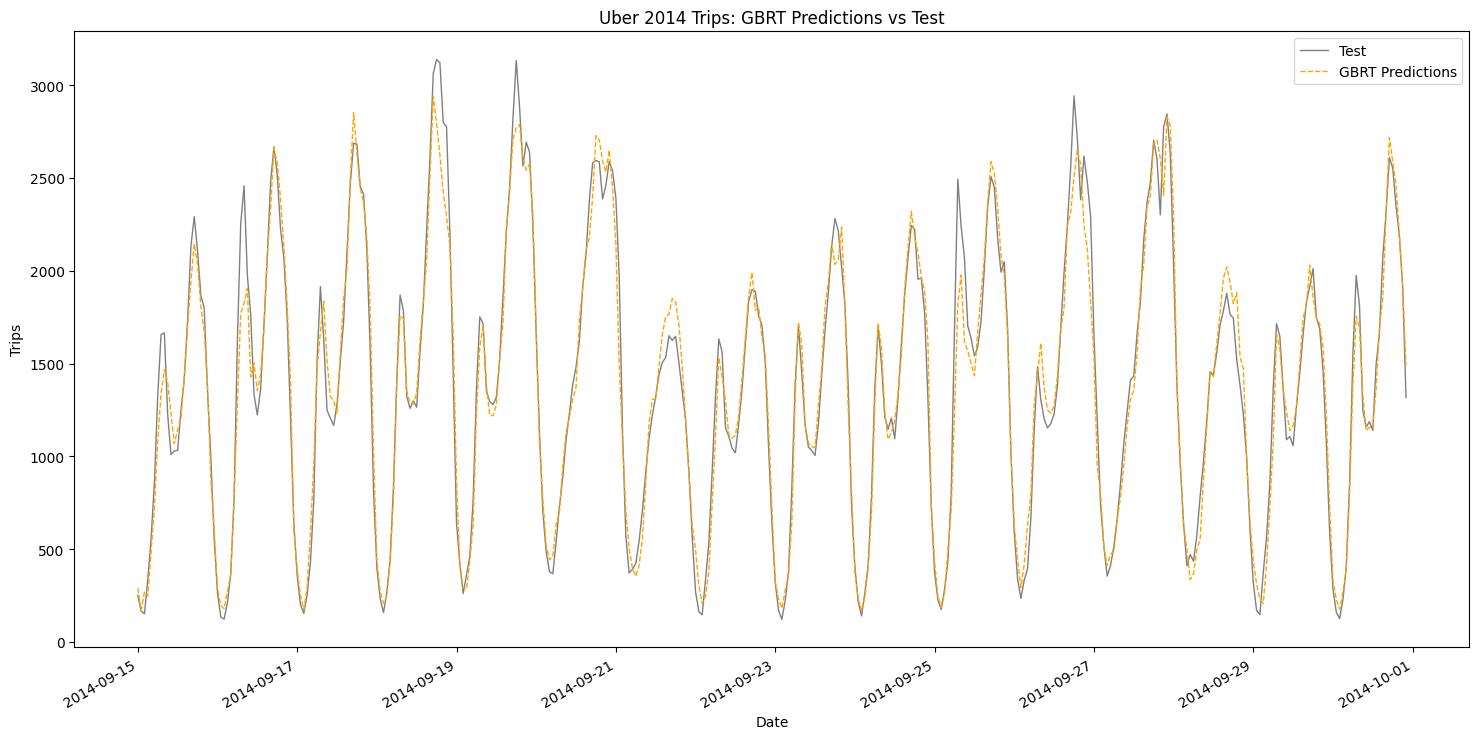

GBTR Percentage Error:	10.54%


In [43]:
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

gbr_model = GradientBoostingRegressor(random_state=seed)

gbr_grid_search = GridSearchCV(estimator=gbr_model, param_grid=gbr_param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
gbr_grid_search.fit(X_train, y_train)

print("Best Random Forest parameters:", gbr_grid_search.best_params_)

gbr_predictions = gbr_grid_search.best_estimator_.predict(X_test)

PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange')],
    'Uber 2014 Trips: GBRT Predictions vs Test')
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)
print(f'GBTR Percentage Error:\t{gbr_mape:.2%}')

Visualizing all models at once

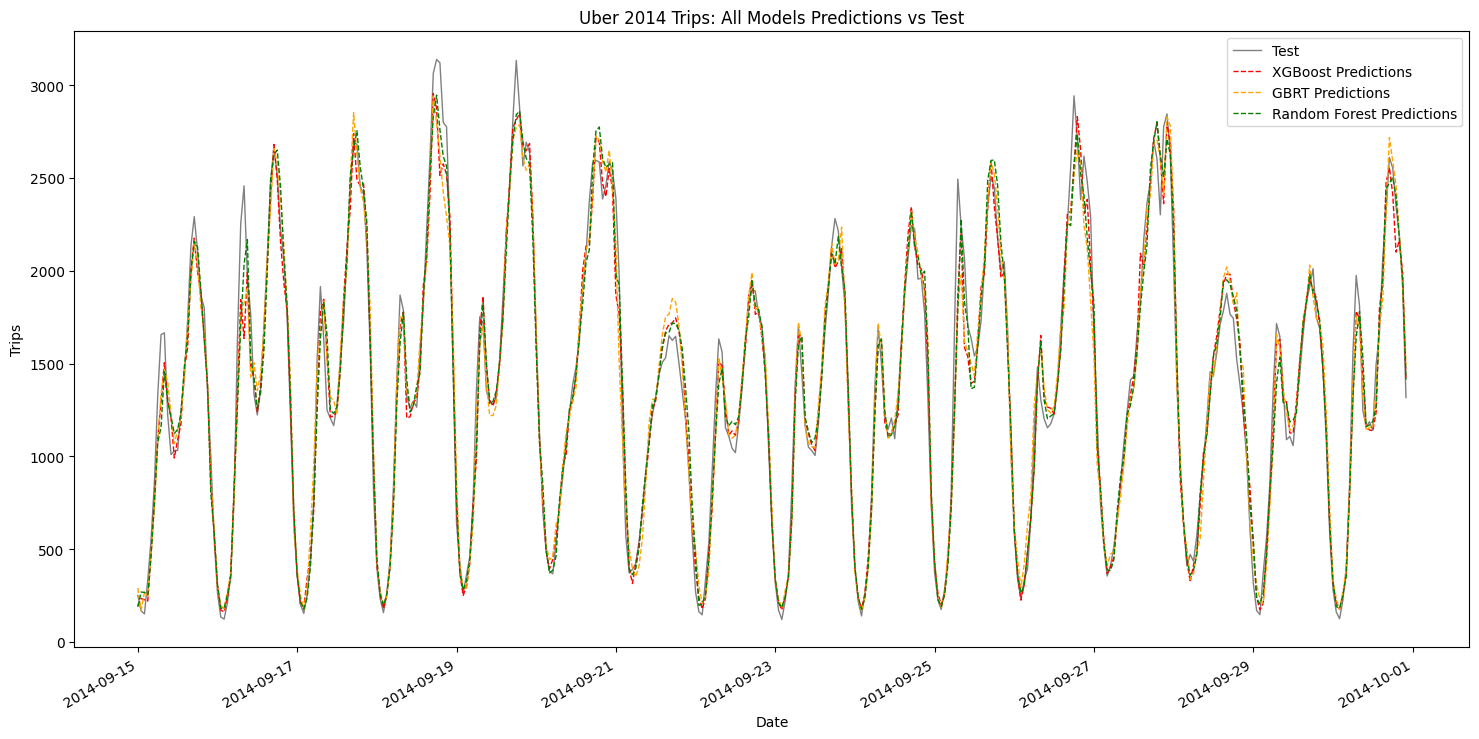

In [44]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,xgb_predictions,'XGBoost Predictions','--','red'),
    (uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange'),
    (uber2014_test.index,rf_predictions,'Random Forest Predictions','--','green')],
    'Uber 2014 Trips: All Models Predictions vs Test')

Ensemble Model

Weights: XGBoost=0.364, Random Forest=0.337, GBRT=0.298


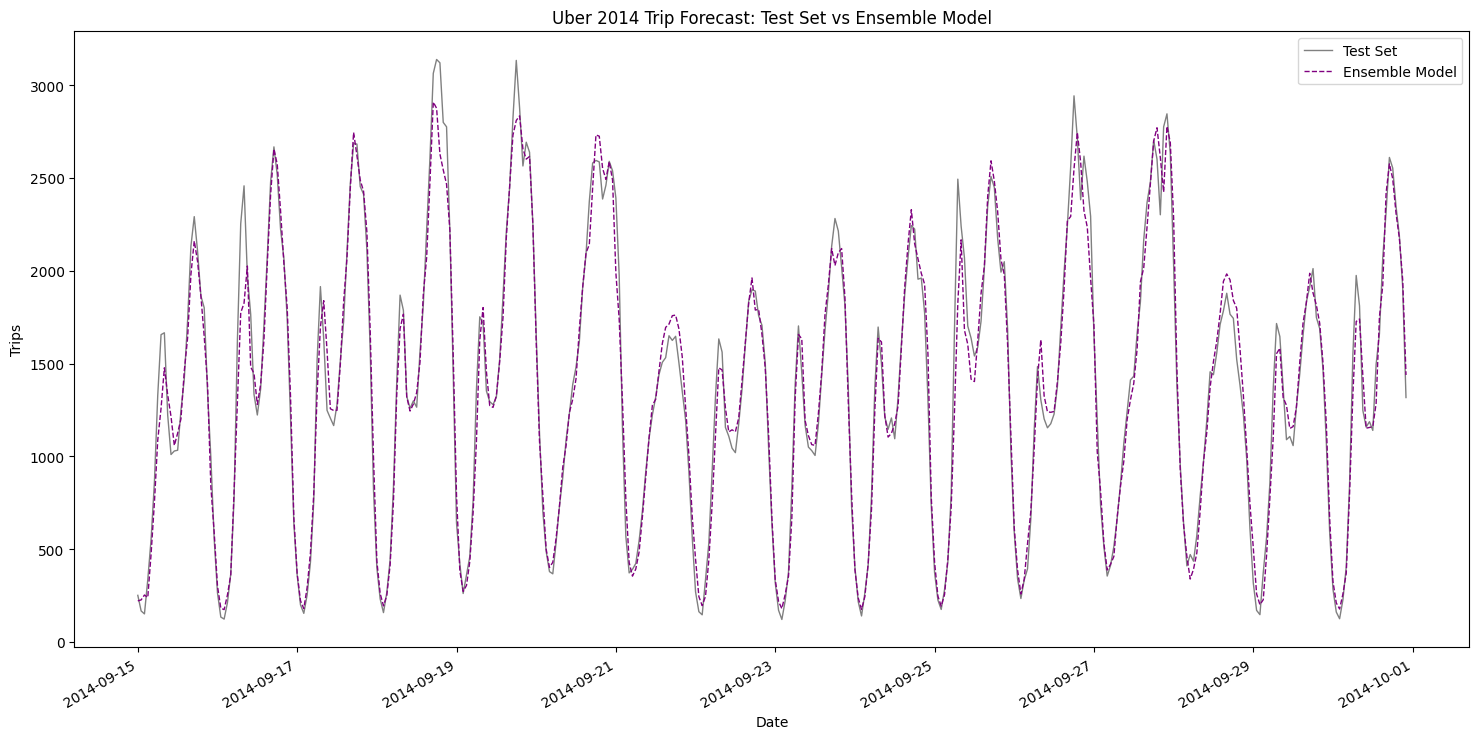

Ensemble Model Percentage Error:	8.92%


In [55]:
# Calculate weights based on the inverse of MAPE
weights = np.array([1/xgb_mape, 1/rf_mape, 1/gbr_mape])
weights = weights / weights.sum()
print(f"Weights: XGBoost={weights[0]:.3f}, Random Forest={weights[1]:.3f}, GBRT={weights[2]:.3f}")

# Create ensemble predictions by combining predictions from XGBoost, Random Forest, and GBRT
ensemble_predictions = (weights[0] * xgb_predictions +
                        weights[1] * rf_predictions +
                        weights[2] * gbr_predictions)

PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test Set', '-', 'gray'),
    (uber2014_test.index, ensemble_predictions, 'Ensemble Model', '--', 'purple')
], 'Uber 2014 Trip Forecast: Test Set vs Ensemble Model')

# Calculate MAPE for the ensemble model using the correct variable name
ensemble_mape = mean_absolute_percentage_error(uber2014_test['Count'], ensemble_predictions)
print(f'Ensemble Model Percentage Error:\t{ensemble_mape:.2%}')

In [46]:
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t{rf_mape:.2%}')
print(f'GBTR MAPE:\t\t{gbr_mape:.2%}')
print(f'Ensemble MAPE:\t\t{ensemble_mape:.2%}')

XGBoost MAPE:		8.63%
Random Forest MAPE:	9.32%
GBTR MAPE:		10.54%
Ensemble MAPE:		8.92%
